# Misil

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, integrate, optimize

## Apartado 1

En primer lugar se introducen las variables geométricas del misil y las características del vuelo.

Variables geométricas:

In [25]:
D = 0.1778		# Diámetro del misil. (m)
r0 = D/2		# Radio del misil. (m)
l = 0.41		# Longitud de la ojiva. (m)
ang_ojiva = 2*np.arctan(D/(2*l)) # Ángulo de la ojiva
l_misil = 3.7	# Longitud del misil (m)
tr = 0.0055		# Ancho máximo de las alas. (m)
cr = 0.315      # Cuerda superficies de control. (m)
cdc = 0.5      	# Cf viscous crossflow.
m = 0.3        # Distancia borde de ataque a punto espesor máximo.
Bc = 2*0.219+D  # Wingspan (m)
deflx_w = 0.6	# Deflexión de la estela, término (1-dew/dalpha)
Bw = 2*0.17+D   # Wingspan ala (m)
Xcg = 2.19      # Distancia al centro de gravedad
Xcp = 2.46      # Distancia al centro de presiones
Xw = 1.91       # Distancia al centro de presiones del ala
Xb = 1          # Distancia al centro de presiones del fuselaje
Xc = 3.6675     # Distancia al centro de presiones del control
m_misil = 152	# Masa del misil (kg)
l_b = 0.08      # Longitud del boattail (m)
Scontrol = 0.049641     # Superficie alar de los controles (m^2)
Sw = 0.0255             # Superficie alar (m^2)

Condiciones del vuelo:

In [4]:
AOA = 0 		# Ángulo de ataque (deg).
M = 4           # Mach de vuelo
h = 10000       # Altura de vuelo (m)
δ_deflx = 10    # Deflexión del control (deg)

En este apartado se ajustan las diferentes variables para que tengan las unidades requeridas, además de calcular otras variables que se precisen y que no sean introducidas por el usuario.

In [5]:
δ_deflx = δ_deflx*np.pi/180
AOA = np.pi*AOA/180
α = AOA
β = (M**2-1)**0.5                          # Parámetro de corrección de compresibilidad
ρ = (1.225*(1-22.558*10**(-6)*h)**4.2559)  # Densidad a la altura de vuelo
dens = ρ * 0.00194032
S = r0**2*np.pi  # Superficie transversal del misil (m^2)
Sb = ((D-0.04)/2)**2*np.pi      # Superficie de la base (m^2)
R_cte = 1718
Tinf = 1.8*(288.15-6.5*h/1000)
Patm = dens*Tinf*R_cte
Tfree = (288.15-6.5*h/1000)
Vsound = (1.4*Tfree*287)**0.5	# Velocidad del sonido a la altura de vuelo
Vinf_I = M*Vsound				# Velocidad de la corriente libre en el sistema internacional
mu0 = 3.58*10**(-7)  # Viscosidad en unidades del sistema imperial
dl = 50         # Divisiones del misil para las funciones de la capa límite.
g = 9.81		# Gravedad (m/s^2)
q = 1/2*Vinf_I**2*ρ

Para el cálculo de la resistencia generada en el misil como consecuencia del vuelo al Mach indicado, se ha tomado la gráfica disponible en el $\textit{Missile Aerodynamics}$ y se ha representado, interpolándose los diferentes valores que se obtienen de esta.

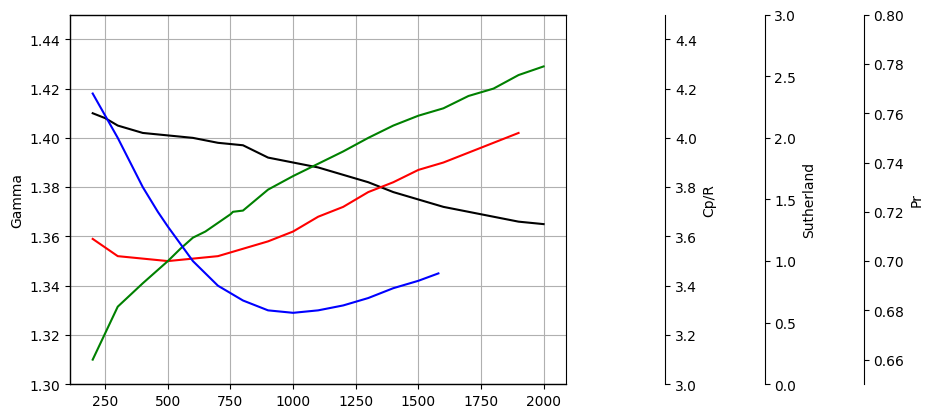

In [6]:
Temp_Pr = [200, 300, 350, 400, 460, 500, 600, 700, 800,
           850, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1580]
Pr_datos = [0.768, 0.75, 0.74, 0.73, 0.72, 0.714, 0.7, 0.69, 0.684,
            0.682, 0.68, 0.679, 0.68, 0.682, 0.685, 0.689, 0.692, 0.695]
Temp_gamma = [200, 250, 300, 400, 500, 600, 700, 800, 900, 1000,
              1100, 1200, 1300, 1350, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
gamma_datos = [1.41, 1.408, 1.405, 1.402, 1.401, 1.4, 1.398, 1.397, 1.392, 1.39,
               1.388, 1.385, 1.382, 1.38, 1.378, 1.375, 1.372, 1.37, 1.368, 1.366, 1.365]
Temp_cp = [200, 300, 400, 500, 600, 700, 800, 900, 1000,
           1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900]
cp_datos = [3.59, 3.52, 3.51, 3.5, 3.51, 3.52, 3.55, 3.58,
            3.62, 3.68, 3.72, 3.78, 3.82, 3.87, 3.9, 3.94, 3.98, 4.02]
Temp_mu = [200, 300, 400, 500, 550, 600, 650, 700, 750, 760, 800, 900,
           1000, 1050, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
mu_datos = [0.2, 0.63, 0.82, 1, 1.1, 1.19, 1.24, 1.31, 1.38, 1.4, 1.41,
            1.58, 1.69, 1.74, 1.79, 1.89, 2, 2.1, 2.18, 2.24, 2.34, 2.4, 2.51, 2.58]
Pr = interpolate.CubicSpline(Temp_Pr, Pr_datos)
gamma = interpolate.CubicSpline(Temp_gamma, gamma_datos)
cp = interpolate.CubicSpline(Temp_cp, cp_datos)
mu = interpolate.CubicSpline(Temp_mu, mu_datos)
def Grafica_plot():
	fig, ax = plt.subplots()
	cp_pl = ax.twinx()
	muRel_pl = ax.twinx()
	Pr_pl = ax.twinx()
	cp_pl.plot(Temp_cp, cp(Temp_cp), 'r-', label="Cp/R")
	cp_pl.set_ylim(3, 4.5)
	cp_pl.spines.right.set_position(("axes", 1.2))
	cp_pl.set_ylabel("Cp/R")

	muRel_pl.plot(Temp_mu, mu(Temp_mu), 'g-', label="Sutherland")
	muRel_pl.spines.right.set_position(("axes", 1.4))
	muRel_pl.set_ylim(0, 3)
	muRel_pl.set_ylabel("Sutherland")

	Pr_pl.plot(Temp_Pr, Pr(Temp_Pr), 'b-', label="Prandtl")
	Pr_pl.set_ylim(0.65, 0.8)
	Pr_pl.spines.right.set_position(("axes", 1.6))
	Pr_pl.set_ylabel("Pr")

	ax.plot(Temp_gamma, gamma(Temp_gamma), "k-", label="Gamma")
	ax.set_ylim(1.3, 1.45)
	ax.set_ylabel("Gamma")
	ax.grid(True)
	plt.show()
Grafica_plot()

A continuación se procede a calcular los diferentes tipos de drag para obtener el total requerido.

El drag debido al lift en un cuerpo esbelto de base cilíndrica es la mitad del que se produce en una placa plana, tal y como se indica en el libro $\textit{Missile Aerodynamics}$. Si el ángulo de ataque es 0, esta resistencia y la denominada como $\textit{viscous crossflow drag}$ son 0.

In [26]:
L_q = 2*np.pi*AOA*r0**2         # Sustentación de una placa plana
D_q = 0.5*L_q*AOA               # Resistencia debida al AOA / presión dinámica
Sc = np.pi*r0**2                # Superficie transversal
Dc_q = cdc*AOA**3*Sc            # Viscous crossflow drag / presión dinámica
print("Resistencia inducida por la sustentación: ", D_q*q)
print("Viscous crossflow drag: ", Dc_q*q)

Resistencia inducida por la sustentación:  0.0
Viscous crossflow drag:  0.0


La resistencia frontal se calculará tanto el la ojiva como en las superficies de control, puesto que son las que generan las ondas de choque correspondientes. Para ello, se han considerado ambas superficies de control de perfil de forma romboidal de parámetro m el indicado en la celda de parámetros geométricos. Esta resistencia se calcula para ángulo de ataque 0, tal y como se indica en la bibliografía.

In [39]:
Vinf = (gamma(Tinf)*R_cte*Tinf)**0.5*M  # Velocidad de la corriente libre
Cd0 = 1/(4*m*(1-m))*4*(tr/cr)**2/β                      # Drag frontal en las alas para AOA = 0
Cdw = (0.083+0.096/M**2)*(ang_ojiva/10)**1.69 * \
    (1-(392*(l/D)**2-32)/(28*(M+18)*(l/D)**2))          # Drag frontal ojiva
D_frontal = Cdw*S*Vinf**2*0.5*dens+Cd0*Sw/S*q
print("Resistencia frontal: ",D_frontal)

Resistencia frontal:  113.98529671752031


In [36]:
Cdb_s = 0.4
Cdb = Cdb_s * Sb/S
Db = Cdb * q * S
print("Drag boattail: ",Db)

Drag boattail:  1184099.5993823796


Finalmente, se calcula la resistencia de fricción. En este caso, los coeficientes adimensionales se encuentran calculados para un área genérica, por lo que la superficie a emplear a la hora de calcular las fuerzas resistentes es directamente la superficie mojada, que será obtenida posteriormente.

Para el cálculo de este drag, se ha empleado el método de la entalpía media tal y como aparece en la bibliografía. Por este motivo, se definieron las siguientes funciones:

In [40]:
# Función de cálculo de la densidad de referencia en la capa límite.
def dens_ref(T): return Patm/(R_cte*T)
def Re(x, ρ, μ): return Vinf*ρ*x/μ 					# Reynolds
# Coeficiente de fricción para caso laminar.
def cf_laminar(x, ρ, μ): return 0.664*Re(x, ρ, μ)**(-0.5)
# Coeficiente de fricción para el caso turbulento.
def cf_turbulento(x, ρ, μ): return 0.370/(np.log10(Re(x, ρ, μ))**2.584)


Después, se establecen las ecuaciones que permitirán calcular las propiedades del fluido en la capa límite laminar y en la turbulenta. 

In [ ]:
def Laminar(T):
	"Función que calcula la capa límite laminar en función de la temperatura exterior"
	Titer = 1800						# Temperatura de inicio de la iteración
	Tref = Titer
	while True:
		r = Pr(Titer)**0.5
		Ts = T*(1+(gamma(T)-1)/2*M**2)
		Trec = T + r*(Ts-T)
		Tref = T + 0.5*(Trec-T)+0.22*r*(Ts-T)
		if abs(Titer-Tref) <= 0.00001:
			break
		Titer = Tref
	mu_ref = mu(Tref)*mu0
	# Promedio
	Re_medio = Re(x=l_misil*3.281, ρ=dens_ref(Tref), μ=mu_ref)
	cf_medio = 0.664*2/(Re_medio**0.5)
	# Local
	x_misil = np.linspace(0.5, l_misil*3.281, dl)
	cf_local = []
	i = 0
	while Re(x=x_misil[i], ρ=dens_ref(Tref), μ=mu_ref) < 10**7:
		# La capa límite laminar está presente hasta el punto de transición.
		cf_local.append(cf_laminar(x=x_misil[i], ρ=dens_ref(Tref), μ=mu_ref))
		i += 1
	xT = x_misil[i-1]
	θ = xT*cf_local[i-1]		# Momentum thickness
	δ = 5*x_misil/(Re(x=x_misil, ρ=dens_ref(Tref), μ=mu_ref)
	               ** 0.5)  # Espesor capa límite
	displ_thickness = 1.72*x_misil / \
		(Re(x=x_misil, ρ=dens_ref(Tref), μ=mu_ref)**0.5)  # Displacement thickness
	return cf_local, xT, θ, δ, dens_ref(Tref), cf_medio, displ_thickness
θ = Laminar(Tinf)[2]			# Punto de transición
xT = Laminar(Tinf)[1]			# Punto de transición
def Turbulenta(T, θ, xT):
	"Función que calcula la capa límite turbulenta en función de la temperatura exterior"
	Titer = 1800
	Tref = Titer
	while True:
		r = Pr(Titer)**(1/3)
		Ts = T*(1+(gamma(T)-1)/2*M**2)
		Trec = T + r*(Ts-T)
		Tref = T + 0.5*(Trec-T)+0.22*r*(Ts-T)
		if abs(Titer-Tref) <= 0.00001:
			break
		Titer = Tref
	mu_ref = mu(Tref)*mu0
	# Promedio
	Re_medio = Re(x=l_misil*3.281, ρ=dens_ref(Tref), μ=mu_ref)
	cf_medio = 0.455/(np.log10(Re_medio)**2.58)

	x_misil = np.linspace(0, l_misil*3.281, dl)
	cf_local = [cf_turbulento(x=coord, ρ=dens_ref(Tref), μ=mu_ref)
             for coord in x_misil if coord > 0]
	Δx = 0
	for i in range(0, len(x_misil)-1):
		θturb = x_misil[i]*cf_local[i]/2
		if abs(θturb - θ) < 0.000001:
			Δx = 2*θ/cf_local[i]  # Referencia Missile Aerodynamics
			break
	x_compensado = xT - Δx

	x_misil_compensado = [(coord - x_compensado) for coord in x_misil]
	def delta_BLayer(x, ρ, μ): return 0.37*x/(Re(x, ρ, μ)**(1/5))

	δ = [delta_BLayer(x=coord, ρ=dens_ref(Tref), μ=mu_ref)/(D*3.281)
            for coord in x_misil_compensado if coord > 0]
	cf_local = [cf_turbulento(x=coord, ρ=dens_ref(Tref), μ=mu_ref)
             for coord in x_misil_compensado if coord > 0]
	return cf_local, δ, dens_ref(Tref)


El punto más problemático de este análisis es la localización de la transición de laminar a turbulento. En este caso se ha obtenido considerando un Reynolds crítico y, para un mejor estudio de los cambios en las propiedades del fluido se requieren otras variables conocidas como $\textit{displacement thickness}$ ($\delta^*$) y $\textit{momentum thickness}$ ($\theta$).

In [ ]:
dens_lam, dens_turb, displ_thickness = Laminar(Tinf)[4], Turbulenta(Tinf, θ, xT)[
    2], Laminar(Tinf)[6]/(D*3.281)
BL_laminar = np.array(Laminar(Tinf)[0])
cf_local = np.append(BL_laminar, Turbulenta(Tinf, θ, xT)[0])
cf_local_func = interpolate.CubicSpline(
	np.linspace(0, l_misil, len(cf_local)), cf_local)
# Relación entre el espesor de la capa límite laminar y el diámetro del misil
delta_rel = Laminar(Tinf)[3]/(D*3.281)
# Relación entre el espesor de la capa límite turbulenta y el diámetro del misil
delta_rel_turb = Turbulenta(Tinf, θ, xT)[1]
def Plots():
	plt.figure(1)
	plt.plot(np.linspace(0, xT, len(delta_rel)), delta_rel, label='Laminar')
	plt.plot(np.linspace(xT, l_misil, len(delta_rel_turb)),
	         delta_rel_turb, label='Turbulenta')
	plt.plot([xT, xT], [delta_rel[-1], delta_rel_turb[0]], ':')
	plt.legend()
	plt.ylabel("δ/D")
	plt.xlabel("Distancia desde el extremo de la ojiva (ft)")

	plt.figure(2)
	plt.plot(np.linspace(0, xT, len(displ_thickness)), displ_thickness)
	plt.ylabel("δ*/D")
	plt.xlabel("Distancia desde el extremo de la ojiva (ft)")

	plt.figure(3)
	plt.plot(np.linspace(0, l_misil, len(cf_local)), cf_local)
	plt.ylabel("Coeficiente de fricción local")
	plt.xlabel("Distancia desde el extremo de la ojiva (ft)")
	plt.show()
Plots()
# Coeficiente de fricción medio. Se integra la función generada como suma de los coeficientes de fricción locales de la
# parte laminar y de la parte turbulenta
cf_medio_lam = integrate.quad(cf_local_func, 0, l)[
    0]*3**0.5 + integrate.quad(cf_local_func, l, xT)[0]
cf_medio_turb = integrate.quad(cf_local_func, xT, l_misil)[0]
Dfricc_lam, Dfricc_turb = cf_medio_lam * Vinf**2 / \
	2 * dens_lam, cf_medio_turb * Vinf**2/2*dens_turb

Dfricc = Dfricc_lam + Dfricc_turb				# En unidades del sistema imperial
def r_ojiva(x): return r0/l*x
# Integral de revolución para obtener el drag total
Dfricc_ojiva, Dfricc_fus = Dfricc_lam*2*np.pi*integrate.quad(r_ojiva, 0, l*3.281)[
    0], (xT - l)*Dfricc_lam*2*np.pi*r0*3.281**2 + 2*np.pi*r0*3.281**2*(l_misil-xT)*Dfricc_turb

De esta forma, se obtiene que el drag producido en las condiciones de vuelo indicadas es de:

In [28]:
Dfricc_misil = Dfricc_ojiva + Dfricc_fus + D_frontal
print("Drag: ",Dfricc_misil)

Drag:  977.6333737267798


## Apartado 2


En la siguiente celda se adimensionalizan las distancias anteriormente introducidas.

In [9]:
Xcg = Xcg/D
Xcp = Xcp/D
Xw = Xw/D
Xb = Xb/D
Xc = Xc/D


In [10]:
CNic = 4/β
CNiw = 4/β
# Coeficiente de fuerza normal debido a alpha del fuselaje
Cnalpha_b = 2
# Coeficiente de fuerza normal debido a alpha del control
Cnalpha_c = (1+D/Bc)*Scontrol/S*CNic*deflx_w
# Coeficiente de fuerza normal debido a alpha de las alas
Cnalpha_w = CNiw*Sw/S*(1+D/Bw)**2
# Coeficiente de fuerza normal debido a alpha
Cn_alpha = Cnalpha_b + Cnalpha_c + Cnalpha_w
# Coeficiente de fuerza normal debido a delta
Cndelta_c = CNic*Scontrol/S*(1+D/Bc)


Con los anteriores coeficientes de fuerzas se obtiene la siguiente fuerza normal total (N).

In [11]:
Cn = Cn_alpha*α + Cndelta_c*δ_deflx
N = Cn*q*S; print("Fuerza normal: ", N)

Fuerza normal:  3413.677333227039


Por otro lado, los cálculos correspondientes a los momentos serían los siguientes:

In [12]:
# Momentos debidos a alpha y delta
Margen_estatico = (Cnalpha_b*(Xcg-Xb)+Cnalpha_c*(Xcg-Xc) +
                   Cnalpha_w*(Xcg-Xw))/(Cnalpha_b+Cnalpha_c+Cnalpha_w)
# Coeficiente de momentos debido al ángulo de ataque
Cm_alpha = Cn_alpha * Margen_estatico
# Coeficiente de momentos debido al ángulo del control
Cm_delta = Cndelta_c * (Xcg-Xc)

Siendo los coeficientes de momentos debidos al ángulo de ataque y deflexión del control los incluidos en Cm; los correspondientes a la aceleración angular en el giro, en Cm_ang; y los debidos al cambio de ángulo de ataque, Cm_AOA.

In [13]:
Cm = Cm_alpha * α + Cm_delta * δ_deflx
Cm_ang = -2*(Cnalpha_b*(Xcg-Xb)**2+Cnalpha_c*(Xcg-Xc)**2+Cnalpha_w*(Xcg-Xw)**2)
Cm_variacion_AOA = -2*CNic*(Sc/S*r0)*(1+D/Bc)*deflx_w*(Xc-Xw)*(Xc-Xcg)
print("Cm: " + str(Cm) +"\nCm_ang: " + str(Cm_ang) + "\nCm_AOA: " + str(Cm_variacion_AOA))

Cm: -3.859549043232042
Cm_ang: -409.1890078036744
Cm_AOA: -11.66322498700653


Finalmente, se indica la aceleración lateral obtenida en g's.

In [14]:
print(Cm_delta*δ_deflx*2*Vinf_I/(D*Cm_ang))
print(Cn*q*S/m_misil)
lat_acc = Cm_delta*δ_deflx*2*Vinf_I/(D*Cm_ang) - Cn*q*S/m_misil
print(lat_acc)
print(lat_acc*m_misil)
g_acc = lat_acc/g
print("Aceleración g: ",g_acc)
print("Radio giro: ",Vinf_I**2/lat_acc)


127.07913424702589
22.458403508072625
104.62073073895327
15902.351072320896
Aceleración g:  10.664702419872912
Radio giro:  13712.260561241354
